In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
!rm -r data/train
!mkdir data/train
!apt update
!apt install -y p7zip-full
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1akr3MnRsk94okzpsURaFdusS1j6rmwbi' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1akr3MnRsk94okzpsURaFdusS1j6rmwbi" -O data/train/data.zip && rm -rf /tmp/cookies.txt
!apt install -y p7zip-full
!7z x data/train/data.zip -odata/train/

^C
mkdir: cannot create directory ‘data/train’: File exists
Get:1 https://deb.nodesource.com/node_16.x focal InRelease [4583 B]
Get:2 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]                
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
0% [Connecting to security.ubuntu.com (185.125.190.39)]^C                  
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package p7zip-full


UnboundLocalError: local variable 'child' referenced before assignment

In [ ]:
!rm -r data/test
!mkdir data/test
!apt update
!apt install -y p7zip-full
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=15ms1RQOrrpZhW177RseZZtt7uOkynk5O' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=15ms1RQOrrpZhW177RseZZtt7uOkynk5O" -O data/test/data.zip && rm -rf /tmp/cookies.txt
!apt install -y p7zip-full
!7z x data/test/data.zip -odata/test/

rm: cannot remove 'data/test': No such file or directory
Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://deb.nodesource.com/node_16.x focal InRelease [4583 B]            
Get:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB] 
Get:4 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [27.5 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [916 kB]m
Get:7 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1556 kB]
Get:8 https://deb.nodesource.com/node_16.x focal/main amd64 Packages [772 B]   
Get:9 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2183 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]    
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 Packages [26.6 kB]
Get:12 http://archive.ubuntu.com/ubuntu fo

In [9]:
path = '/datasets/vgg-face'
train_path = 'data/train'
test_path = 'data/test'

# Load images

Select folders of the same person

In [4]:
def list_files_in_folder(filepath):
    filepath = tf.strings.join([filepath, f'{os.path.sep}*.jpg'])
    
    return tf.data.Dataset.list_files(filepath, shuffle=True)

In [5]:
def get_label(filepath):
    return tf.strings.split(filepath, os.path.sep)[2] # 4

In [6]:
def process_image(filepath):
    label = get_label(filepath)
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    
    return tf.reshape(img, (128, 128, 3)) / 255.0, label

In [10]:
def create_dataset(path):
    dataset = tf.data.Dataset.list_files(f'{path}/*', shuffle=True)
    dataset = dataset.map(list_files_in_folder)
    
    return dataset
    
def create_batch(dataset, batch_size, faces_per_identity):
    identities = batch_size // faces_per_identity
    first = True
    
    identity_dataset = dataset.take(identities)

    for identity in identity_dataset:
        if first:
            faces = identity.take(faces_per_identity)
            first = False
        else:
            faces = faces.concatenate(identity.take(faces_per_identity))

    faces = faces.map(process_image)
    batch = faces.batch(batch_size)
    
    return batch

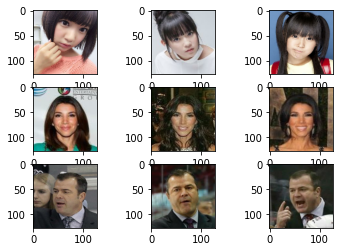

In [13]:
dataset = create_dataset(train_path)
batch = create_batch(dataset, batch_size=9, faces_per_identity=3)

fig, axs = plt.subplots(3, 3)
i = 0

for minibatch in batch.take(1):
    for i in range(9):
        axs[i // 3, i % 3].imshow(minibatch[0][i])
        i += 1

# Create model

In [14]:
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), 0.2) # alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

def calculate_distances(embeddings):
    embedding_matrix = tf.linalg.matmul(embeddings, tf.transpose(embeddings))
    norm_vector = tf.expand_dims(tf.linalg.diag_part(embedding_matrix), axis=1)

    distances = norm_vector - 2.0 * embedding_matrix + tf.transpose(norm_vector)
    distances = tf.maximum(distances, 0.0)
    
    mask = tf.cast(tf.equal(distances, 0.0), dtype=tf.float32)

    distances = distances + mask * 1e-16
    distances = tf.sqrt(distances) * (1.0 - mask)
    
    return distances

def get_triplet_mask(labels):
    batch_size = tf.shape(labels)[0]
    indices_equal = tf.cast(tf.eye(batch_size), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)
    
    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)
    
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    mask = tf.logical_and(distinct_indices, valid_labels)
    
    return mask

def batch_triplet_loss(labels, embeddings, alpha):
    distances = calculate_distances(embeddings)
    
    # loss for i anchor, j positive and k negative
    triplet_loss = tf.expand_dims(distances, axis=2) - tf.expand_dims(distances, axis=1) + alpha
    
    valid_mask = get_triplet_mask(labels)
    valid_mask = tf.cast(valid_mask, tf.float32)
    
    triplet_loss = tf.multiply(triplet_loss, valid_mask)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.cast(tf.greater(triplet_loss, 1e-16), tf.float32)
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(valid_mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)
    
    return triplet_loss

In [40]:
base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(128, 128, 3), weights="imagenet")
base_model.trainable = False

inputs = tf.keras.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(128)(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1048704   
                                                                 
Total params: 22,851,488
Trainable params: 1,048,704
Non-trainable params: 21,802,784
_________________________________________________________________


In [43]:
batch_size = 500
faces_per_identity = 10

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
alpha = 0.2

train_dataset = create_dataset(train_path)
test_dataset = create_dataset(test_path)

In [44]:
epochs = 300
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    
    train_batch = create_batch(train_dataset, batch_size=batch_size, faces_per_identity=faces_per_identity)

    for x_batch_train, y_batch_train in train_batch:
        with tf.GradientTape() as tape:
            embeddings = model(x_batch_train, training=True)
            loss_value = batch_triplet_loss(y_batch_train, embeddings, alpha)

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        test_loss_value = 0
            
        print(
            "Training loss (for one batch) at step %d: %.4f Test loss %.4f"
            % (1, float(loss_value), float(test_loss_value))
        )


Start of epoch 0
Training loss (for one batch) at step 1: 3.4702 Test loss 0.0000

Start of epoch 1
Training loss (for one batch) at step 1: 3.6655 Test loss 0.0000

Start of epoch 2
Training loss (for one batch) at step 1: 3.1469 Test loss 0.0000

Start of epoch 3
Training loss (for one batch) at step 1: 3.1222 Test loss 0.0000

Start of epoch 4
Training loss (for one batch) at step 1: 3.0676 Test loss 0.0000

Start of epoch 5
Training loss (for one batch) at step 1: 3.3539 Test loss 0.0000

Start of epoch 6
Training loss (for one batch) at step 1: 2.9864 Test loss 0.0000

Start of epoch 7
Training loss (for one batch) at step 1: 2.9883 Test loss 0.0000

Start of epoch 8
Training loss (for one batch) at step 1: 3.0515 Test loss 0.0000

Start of epoch 9
Training loss (for one batch) at step 1: 2.9538 Test loss 0.0000

Start of epoch 10
Training loss (for one batch) at step 1: 3.0368 Test loss 0.0000

Start of epoch 11
Training loss (for one batch) at step 1: 3.0193 Test loss 0.0000

S